# Recurrent Neural Network Assignment
## Gabriel Marcelino, Grant Burk, Eli   
## CST-435
**October 30, 2024**  


## Problem Statement
Goal is to develop a neural network model capable of predicting the next word in a sentence based on a given sequence of words. This model should use a recurrent neural network (RNN), specifically an LSTM architecture, to understand the sequential context of text data. By training on a large corpus of text, the model will be able to suggest the most likely word to follow a given input sequence.

## 1. Import Requirements and Load data


In [11]:
import kagglehub
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import sent_tokenize
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split


path = kagglehub.dataset_download("mikeortman/wikipedia-sentences")

print("Path to dataset files:", path)

# List files in the dataset directory
files = os.listdir(path)
print("Files in dataset:", files)

# Select a subset of files (e.g., first 10 files)
subset_files = files[:10]
print("Subset of files:", subset_files)

# Load and process the subset of files
data = ""
for file in subset_files:
    with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
        data += f.read()

print("Loaded data from subset of files")


# Taking too long to run -> Use only the first 100,000 characters for testing
data = data[:1000000]


Path to dataset files: /Users/gabriel/.cache/kagglehub/datasets/mikeortman/wikipedia-sentences/versions/3
Files in dataset: ['wikisent2.txt']
Subset of files: ['wikisent2.txt']
Loaded data from subset of files


## 2. Visualize data

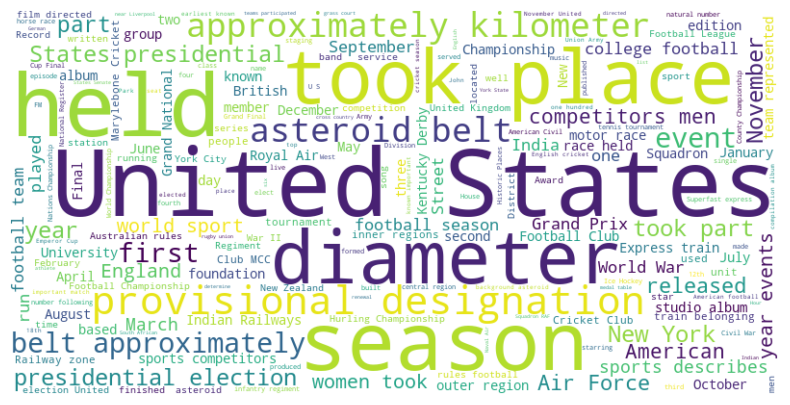

In [12]:
# Visualize data with a word cloud to see most commom words

# Generate and display word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 3. Prepare Data

In [13]:
# Sample of data before
print(data[:1000])

# Step 1: Split the text into sentences
sentences = sent_tokenize(data)

# Step 2: Remove punctuation from each sentence using a compiled regular expression
punctuation_re = re.compile(r'[^\w\s]')
sentences = [punctuation_re.sub('', sentence) for sentence in sentences]

# Sample of data after removing punctuation and splitting into sentences
print(sentences[:10])

# Step 3: Convert each sentence into a sequence of integers using Keras tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)  # Fit on the entire dataset at once
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)  # Convert each sentence into a sequence of integers
# preview the first 10 sequences
print(sequences[:10])

0.000123, which corresponds to a distance of 705 Mly, or 216 Mpc.
000webhost is a free web hosting service, operated by Hostinger.
0010x0010 is a Dutch-born audiovisual artist, currently living in Los Angeles.
0-0-1-3 is an alcohol abuse prevention program developed in 2004 at Francis E. Warren Air Force Base based on research by the National Institute on Alcohol Abuse and Alcoholism regarding binge drinking in college students.
0.01 is the debut studio album of H3llb3nt, released on February 20, 1996 by Fifth Colvmn Records.
001 of 3 February 1997, which was signed between the Government of the Republic of Rwanda, and FAPADER.
003230 is a South Korean food manufacturer.
0.04%Gas molecules in soil are in continuous thermal motion according to the kinetic theory of gasses, there is also collision between molecules - a random walk.
0.04% of the votes were invalid.
005.1999.06 is the fifth studio album by the South Korean singer and actress Uhm Jung-hwa.
005 is a 1981 arcade game by Sega.

## 4. Create Features and Labels

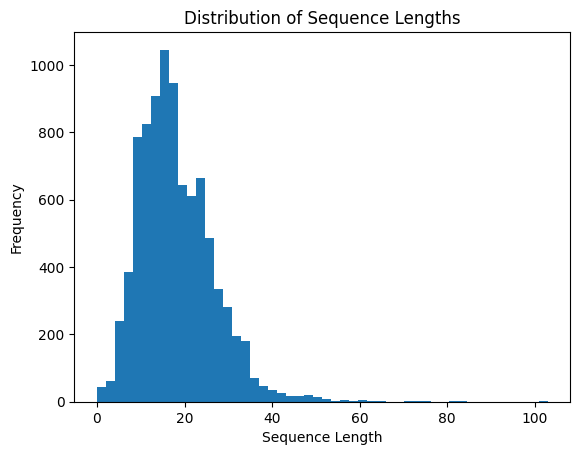

Adjusted max sequence length: 50

First 10 input-output pairs (before padding):
Input sequence: [7316], Output word: 52
Input sequence: [7316   52], Output word: 7317
Input sequence: [7316   52 7317], Output word: 8
Input sequence: [7316   52 7317    8], Output word: 5
Input sequence: [7316   52 7317    8    5], Output word: 3161
Input sequence: [7316   52 7317    8    5 3161], Output word: 3
Input sequence: [7316   52 7317    8    5 3161    3], Output word: 7318
Input sequence: [7316   52 7317    8    5 3161    3 7318], Output word: 7319
Input sequence: [7316   52 7317    8    5 3161    3 7318 7319], Output word: 106
Input sequence: [7316   52 7317    8    5 3161    3 7318 7319  106], Output word: 4886
Shape of X after padding: (436884, 49)

Shape of X: (436884, 49)
Shape of y: (436884,)
Vocabulary size: 17658
One-hot encoding completed
Shape of X_small: (10000, 49)
Shape of y_small: (10000, 17658)
Shape of X_train: (8000, 49)
Shape of X_test: (2000, 49)


In [14]:
# Check the distribution of sequence lengths
sequence_lengths = [len(seq) for seq in sequences]
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

# Set a reasonable max sequence length based on the distribution
max_sequence_len = min(max(sequence_lengths), 50)  # Use 50 as a reasonable length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='post')
print(f"Adjusted max sequence length: {max_sequence_len}")

# Create input sequences and output words
X = []
y = []

for sentence in padded_sequences:
    for i in range(1, len(sentence)):
        X.append(sentence[:i])
        y.append(sentence[i])

# Print first 10 input sequences and output words (before padding)
print("\nFirst 10 input-output pairs (before padding):")
for i in range(min(10, len(X))):
    print(f"Input sequence: {X[i]}, Output word: {y[i]}")

# Pad input sequences
X = pad_sequences(X, maxlen=max_sequence_len-1, padding='post')
print(f"Shape of X after padding: {X.shape}")


# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
print(f"\nShape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Convert output words to one-hot encoding
vocab_size = len(word_index) + 1
print(f"Vocabulary size: {vocab_size}")
y = to_categorical(y, num_classes=vocab_size)
print("One-hot encoding completed")

# Reduce the size of the dataset for testing
X_small = X[:10000]
y_small = y[:10000]
print(f"Shape of X_small: {X_small.shape}")
print(f"Shape of y_small: {y_small.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

## 5. Build Model

In [15]:
# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors.")

# Create an embedding matrix
embedding_dim = 50  # Set embedding_dim to 50 to match GloVe embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Build the model
model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_len-1, trainable=False),
    LSTM(128, return_sequences=True),
    Dropout(0.3),  # Increased dropout rate
    LSTM(128),
    Dropout(0.3),  # Increased dropout rate
    Dense(128, activation='relu'),
    Dropout(0.3),  # Increased dropout rate
    Dense(vocab_size, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,  # Increased number of epochs
    batch_size=64,  # Reduced batch size
    validation_split=0.2,
    verbose=1
)

# Function to generate next word
def predict_next_word(text, num_words=1):
    # Tokenize the input text
    sequence = tokenizer.texts_to_sequences([text])[0]
    
    for _ in range(num_words):
        # Pad the sequence
        padded = pad_sequences([sequence], maxlen=max_sequence_len-1, padding='post')
        
        # Get prediction
        pred = model.predict(padded, verbose=0)
        next_word_idx = np.argmax(pred[0])
        
        # Append prediction to sequence
        sequence = np.append(sequence, next_word_idx)
    
    # Convert indices back to words
    predicted_text = []
    for idx in sequence[len(sequence)-num_words:]:
        for word, index in word_index.items():
            if index == idx:
                predicted_text.append(word)
                break
    
    return " ".join(predicted_text)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

# Example usage
test_sentence = "The quick brown"
completed = predict_next_word(test_sentence, num_words=2)
print(f"Original: {test_sentence}")
print(f"Completed: {test_sentence} {completed}")

# Function to evaluate model on test set
def evaluate_model():
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

# Run evaluation
evaluate_model()

Loaded 400000 word vectors.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6259 - loss: 6.4046 - val_accuracy: 0.6737 - val_loss: 3.2432
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6686 - loss: 3.0218 - val_accuracy: 0.6737 - val_loss: 3.2967
Epoch 3/10
  1/100 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.6094 - loss: 3.2016

KeyboardInterrupt: 